# 40.220 The Analytics Edge Final Revision

Note: This set of notes serves as a quick refresher for material from Week 8 onwards and is not intended to substitute the class material. Please read your notes as well :)

## 1. CART (Classification And Regression Trees)

Importing necessary libraries

In [ ]:
library(rpart)
library(rpart.plot)
library(caTools)
library(ROCR)

Load example dataset

In [3]:
supreme <- read.csv("Dataset/supreme.csv")

In [ ]:
str(supreme)

In [ ]:
summary(supreme)

Preprocessing of dataset. We want to predict whether Judge Stevens reverses (labelled as 1) or affirms (labelled as 0) the lower court direction.

In [8]:
stevens <- subset(supreme[,c("docket","term","stevdir","petit","respon","circuit","unconst","lctdir","issue")], supreme$stevdir!=9)
stevens$rev <- as.integer((stevens$stevdir==0&stevens$lctdir=="conser")|(stevens$stevdir==1&stevens$lctdir=="liberal")) # cases when steven reverse the lower court direction

Splitting the dataset into train and test

In [9]:
set.seed(1)
spl<-sample.split(stevens$rev, SplitRatio = 0.7)
train<-subset(stevens, spl==TRUE)
test<-subset(stevens, spl==FALSE)

### Training (classification tree)

Training a classification tree with _rev_ as the output and the other variables (i.e. _petit, respon, circuit, unconst, lctdir, issue_) as predictors

In [60]:
# use as.factor to change into class labels for classification problem
cart<-rpart(as.factor(rev)~petit+respon+circuit+unconst+lctdir+issue, data=train)
# OR
cart<-rpart(rev~petit+respon+circuit+unconst+lctdir+issue, data=train, method="class")
cart

n= 434 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 434 195 1 (0.44930876 0.55069124)  
    2) lctdir=liberal 205  82 0 (0.60000000 0.40000000)  
      4) circuit=10th,11th,1st,3rd,4th,5th,6th,7th,8th,DC 109  31 0 (0.71559633 0.28440367)  
        8) respon=DEF,ER,IP,POL,STATE 36   3 0 (0.91666667 0.08333333) *
        9) respon=BUSINESS,EE,INDIAN,OF,OTHER,US 73  28 0 (0.61643836 0.38356164)  
         18) petit=ER,IP,OF,POL 19   2 0 (0.89473684 0.10526316) *
         19) petit=BUSINESS,CITY,OTHER,STATE,US 54  26 0 (0.51851852 0.48148148)  
           38) issue=CP,FA 16   4 0 (0.75000000 0.25000000) *
           39) issue=CR,DP,ECN,FED,JUD,PRIV,UN 38  16 1 (0.42105263 0.57894737)  
             78) circuit=10th,3rd,4th,5th,8th 25  12 0 (0.52000000 0.48000000)  
              156) respon=BUSINESS,OTHER 18   7 0 (0.61111111 0.38888889) *
              157) respon=EE,INDIAN,OF 7   2 1 (0.28571429 0.71428571) *
             79) circuit=11th,6th,7th 13   3

Note on Classification Tree:
* Intuition of how the training works:
  1. Start with all observations in a single region
  2. Select predictor variable $X_j$ and cutpoint in the variable $S$ that maximizes the impurity reduction in the two child regions/buckets. Impurity can be measured using Gini, Entropy and Misclassification. The smaller the values, the more pure the buckets 
  3. Split the parent region into child regions using the selected predictor variable $X_j^+$ and $S^+$
  4. Repeat step 2 and 3 until a stopping criterion is reached, which is the number of terminal nodes in the tree
  
* Example of calculating Gini for a split:
  
  \begin{equation*}
  Gini\ index\ for\ mth\ region = \sum_{k=1}^K P_{mk}(1-P_{mk})
  \end{equation*}
  
  _where p represents the proportion of training obs in the mth region for the kth class_
  
  Suppose there are two classes: {0,1} and bucket 1 splits into bucket 2 and 3:
  
Bucket 1| Class 0 | Class 1
--- | --- | ---
Raw count| 10 | 5

Bucket 2| Class 0 | Class 1
--- | --- | ---
Raw count| 1 | 4

Bucket 3| Class 0 | Class 1
--- | --- | ---
Raw count| 9 | 1
 
  \begin{equation*}
  Gini\ for\ bucket\ 1 = \frac{10}{15}*\frac{5}{15} + \frac{5}{15}*\frac{10}{15} = \frac{4}{9}\\\
  Gini\ for\ bucket\ 2 = \frac{1}{5}*\frac{4}{5} + \frac{4}{5}*\frac{1}{5} = \frac{8}{25}\\\
  Gini\ for\ bucket\ 3 = \frac{9}{10}*\frac{1}{10} + \frac{1}{10}*\frac{9}{10} = \frac{9}{50}
  \end{equation*}

* Example of calculating impurity reduction for a split using Gini

\begin{equation*}
Impurity\ reduction = Impurity(parent) - \Big(\frac{N(left)}{N(parent)} * Impurity(left) + \frac{N(right)}{N(parent)} * Impurity(right) \Big)\\\
Impurity\ reduction = \frac{4}{9} - \Big(\frac{5}{15} * \frac{8}{25} + \frac{10}{15} * \frac{9}{50}\Big)
\end{equation*}


* Cost complexity parameter (cp) is a penalty for overfitting to the training data. It is assoicated to the number of terminal nodes in the trees. The higher the value of cp, the less complex the model. cp is default to 0.01.
* By deafult, running rpart() will automatically execute pruning using k-fold cross validation.

### Training (regression tree)
Training a regression tree

In [44]:
# code is exactly the same, except the output is a continuous variable, not a factor

Note on Regression Tree:
* The steps to spliting the trees are similar to classification tree, except that the objective function is to minimize the residual sum of squared:
\begin{equation*}
\min_{j=1,..p} \min_{s} \sum_{i:x_{ij}<s} (y_{i}-\hat{y}_{R1})^{2} + \sum_{i:x_{ij}>=s} (y_{i}-\hat{y}_{R2})^{2}
\end{equation*}

_where j refers to the predictors and s refers to the cutpoint in variable j_

### Results of model

Reading the output of CART model
* {node no} || {variable and values used for split} || {total no of obs in node} || {no of misclassified obs in node} || {predicted value for node} || {predicted probabilities/proportion}

* Notice that 2 and 3 are branched from the same parent node (total number of obs adds up >> 205+229=434). You can find the child node by using this formula: $2n$ (left child) and $2n+1$ (right child), where n is the index of the parent node

<img src="Images/bin_tree.png" width="60%">

Plotting the CART

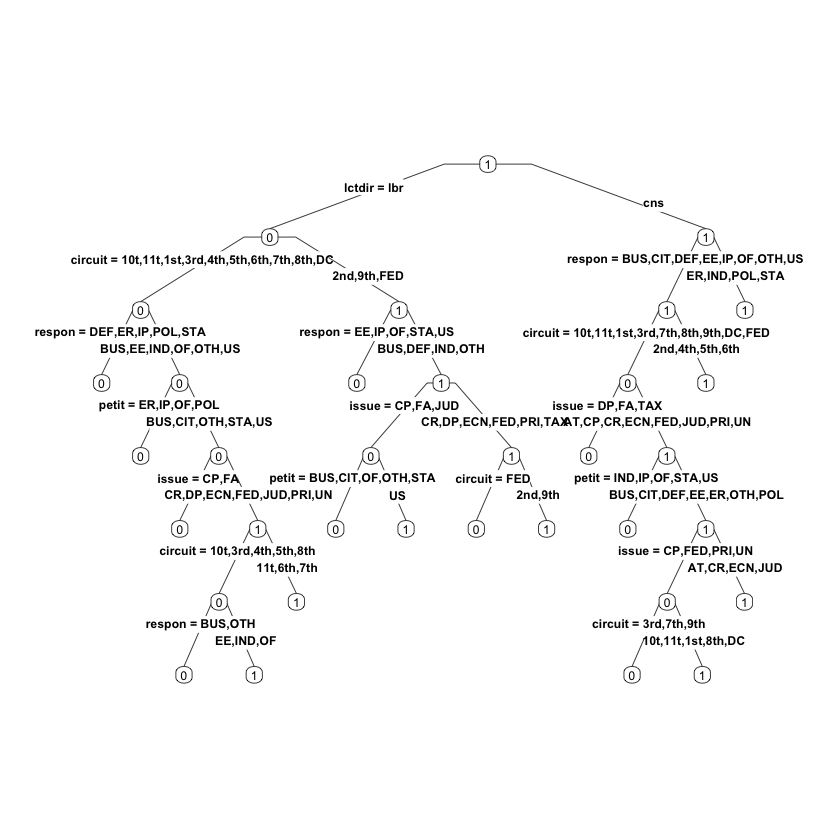

In [22]:
# plots the tree and adds label to the tree
# prp(cart1)
# labels nodes with the predicted label, not just the leaves
# prp(cart1, type=1)
# draws separate labels for left and right directions for all nodes and label nodes
prp(cart, type=4)
# also plot probability per class of observations
# prp(cart1, extra=4, type=4)
# probability times fraction of observations at node (sum across level is 1)
# prp(cart1,extra=9,type=4)

Display cp table for model
* shows different values of alpha tried
* from smallest tree to largest one
* rel error is the training loss
* xerror is loss from the cross validation set

In [23]:
printcp(cart)


Classification tree:
rpart(formula = rev ~ petit + respon + circuit + unconst + lctdir + 
    issue, data = train, method = "class")

Variables actually used in tree construction:
[1] circuit issue   lctdir  petit   respon 

Root node error: 195/434 = 0.44931

n= 434 

        CP nsplit rel error  xerror     xstd
1 0.210256      0   1.00000 1.00000 0.053142
2 0.035897      1   0.78974 0.78974 0.051116
3 0.023077      3   0.71795 0.84615 0.051861
4 0.018803      5   0.67179 0.83590 0.051737
5 0.012821      9   0.57949 0.86154 0.052037
6 0.010256     11   0.55385 0.87692 0.052203
7 0.010000     17   0.49231 0.86154 0.052037


Plot cross-validated error across different cp

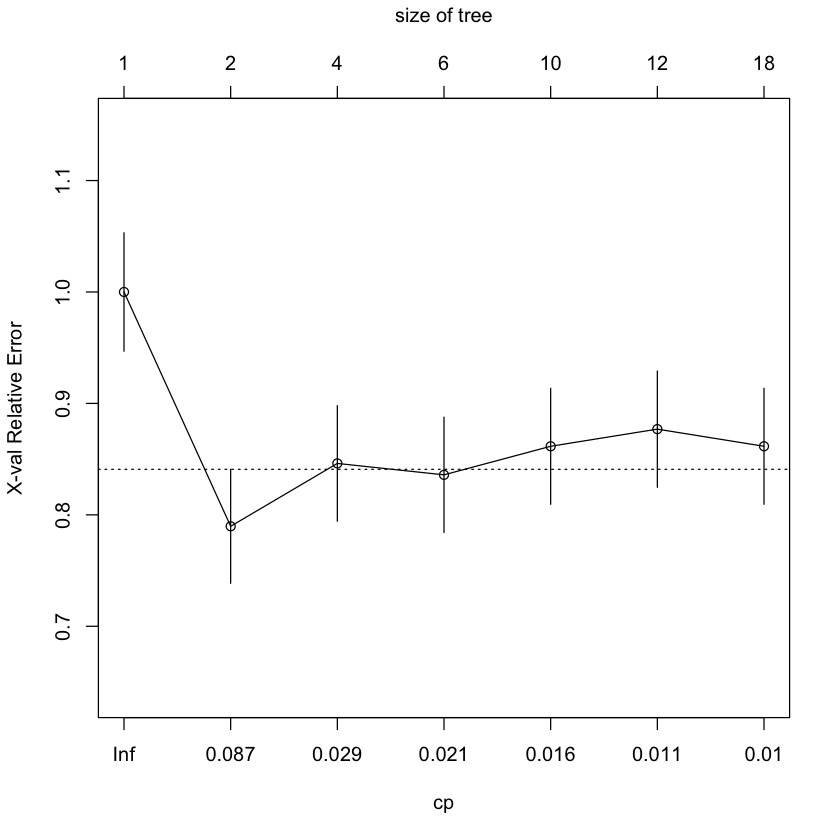

In [24]:
plotcp(cart)

### Pruning the tree

When finding the model with the lowest cross-validated error, use a cp value higher than the corresponding cp value to guaranteee the pruned tree. E.g. round up to the nearest second decimal place

In [36]:
prune_cart<-prune(cart,cp=0.036)
prune_cart

n= 434 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 434 195 1 (0.4493088 0.5506912)  
  2) lctdir=liberal 205  82 0 (0.6000000 0.4000000) *
  3) lctdir=conser 229  72 1 (0.3144105 0.6855895) *

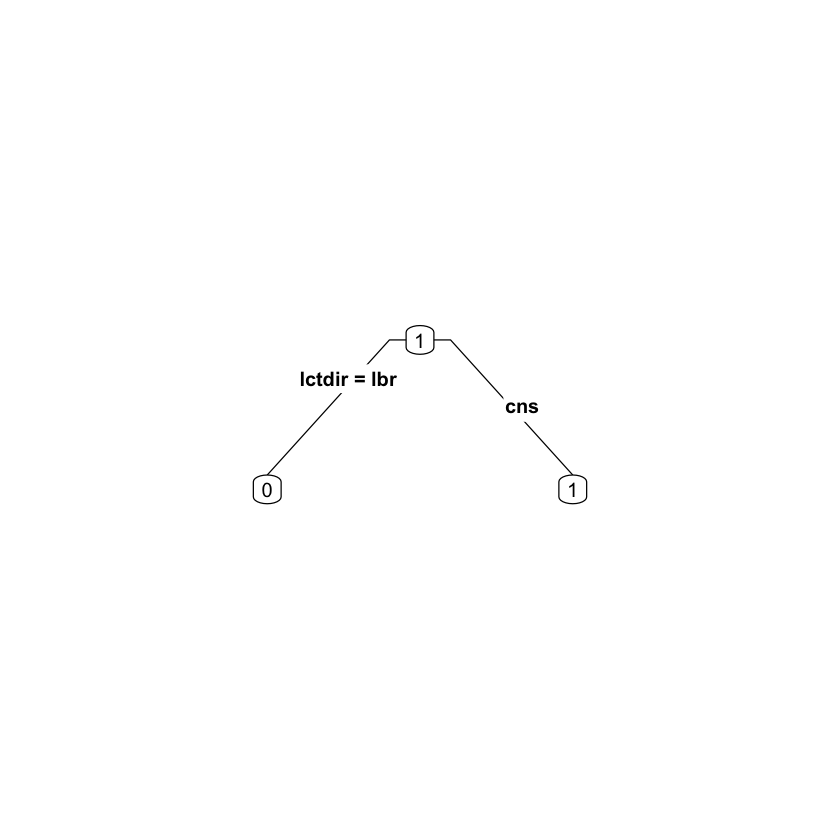

In [45]:
prp(prune_cart, type=4)

### Building a more complex tree

Setting the cp parameter lower in rpart allows the building of a more complex tree

In [43]:
modified_cart<-rpart(as.factor(rev)~petit+respon+circuit+unconst+lctdir+issue, data=train, cp=0.00000001)
printcp(modified_cart)


Classification tree:
rpart(formula = as.factor(rev) ~ petit + respon + circuit + unconst + 
    lctdir + issue, data = train, cp = 1e-08)

Variables actually used in tree construction:
[1] circuit issue   lctdir  petit   respon 

Root node error: 195/434 = 0.44931

n= 434 

          CP nsplit rel error  xerror     xstd
1 0.21025641      0   1.00000 1.00000 0.053142
2 0.03589744      1   0.78974 0.78974 0.051116
3 0.02307692      3   0.71795 0.88205 0.052256
4 0.01880342      5   0.67179 0.88718 0.052307
5 0.01282051      9   0.57949 0.88718 0.052307
6 0.01025641     11   0.55385 0.89231 0.052358
7 0.00769231     17   0.49231 0.86154 0.052037
8 0.00000001     19   0.47692 0.86154 0.052037


### Prediction

Class prediction

In [ ]:
cart_predict_class<-predict(cart, newdata=test, type='class')
cart_predict_class

Probability prediction for ALL classes

In [ ]:
cart_predict_prob<-predict(cart, newdata=test)
cart_predict_prob

Note: to obtain probability prediction for class label 1 in binary classification, use this:

In [ ]:
cart_predict_prob[,2]

### ROC curve and AUC

To obtain the ROC curve, you must feed in probabilities, NOT labels

In [56]:
ROCRpred<-prediction(cart_predict_prob[,2], test$rev)

Plotting the ROC curve

In [ ]:
ROCRperf <- performance(ROCRpred, measure='tpr', x.measure='fpr')
plot(ROCRperf)

Obtaining the AUC value

In [ ]:
performance(ROCRpred, measure='auc')

## 2. Random Forest

Importing necessary library

In [59]:
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


Key features of RF
* It is a combination of decision trees, known as an ensemble model, where the final prediction is obtained using majority vote or averaging across trees
* Each CART trains on a subset of data that is randomly chosen with replacement (bootstrapping), preventing overfitting to dataset
* At each split, a random sample of $m=\sqrt{p}$ predictors are considered, ensuring low covariance between CART

### Training

In [61]:
forest<-randomForest(as.factor(rev)~petit+respon+circuit+unconst+lctdir+issue, data=train)

### Prediction

Class prediction

In [ ]:
forest_predict_class<-predict(forest, newdata=test)
forest_predict_class

Probability prediction

In [ ]:
forest_predict_prob<-predict(forest, newdata=test, type='prob')
forest_predict_prob

### Determining the 'best' parameter

__Metric 1: Reduction in impurity__

In [69]:
importance(forest) # shows the purity of each variable. the higher the better

,MeanDecreaseGini
petit,31.752584
respon,35.587801
circuit,47.526841
unconst,6.449626
lctdir,14.708817
issue,31.772368


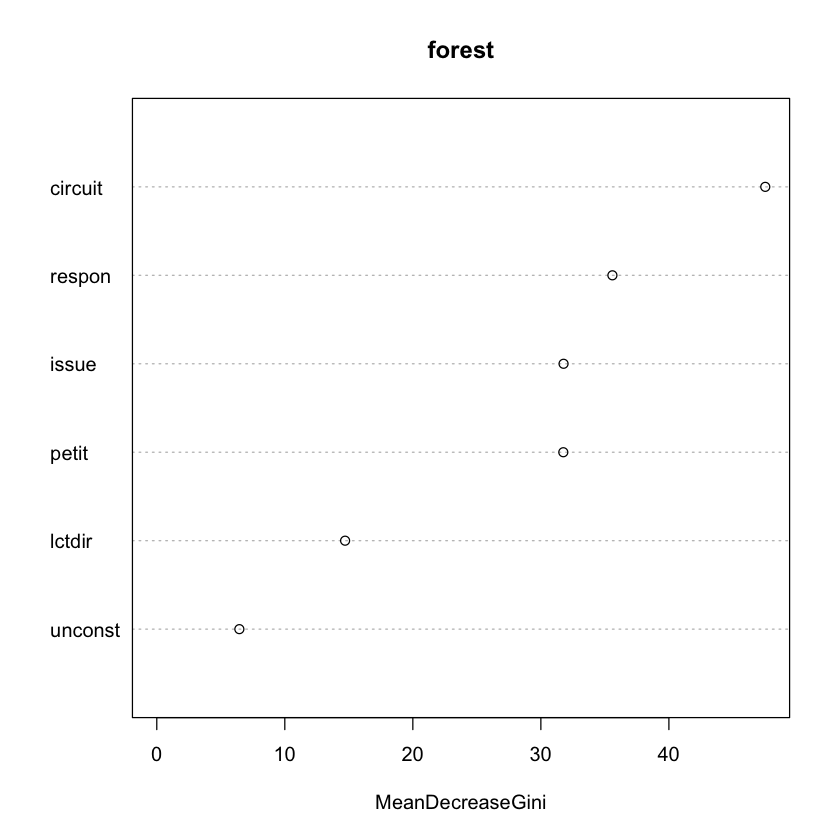

In [70]:
varImpPlot(forest) # plots the purity of each variable

__Metric 2: Frequency of variable use__

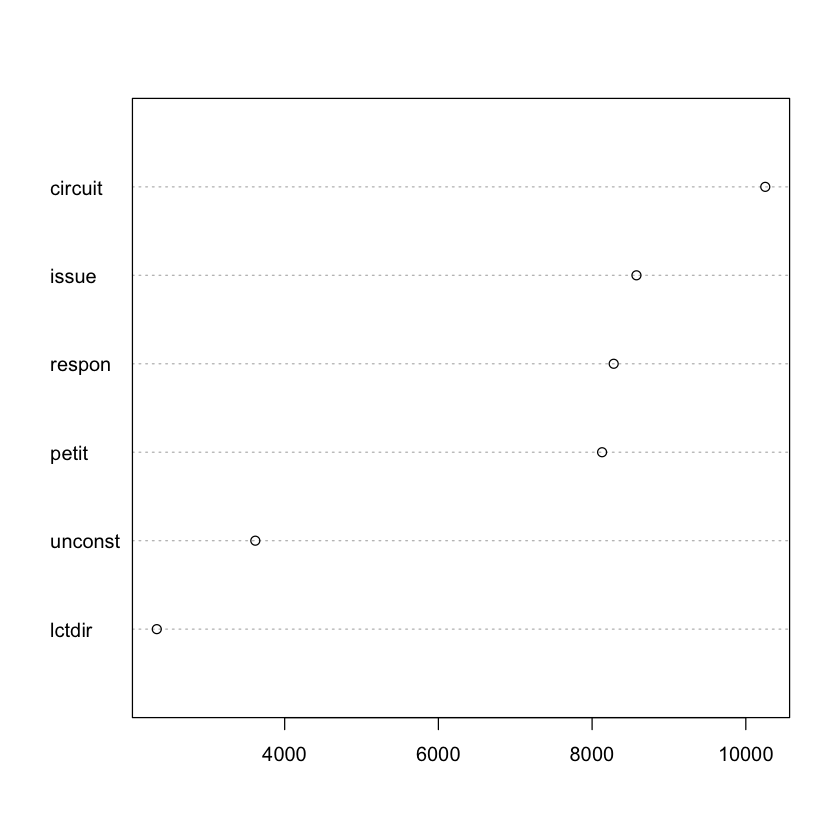

In [72]:
vu<-varUsed(forest,count=TRUE) # get all the variables
vusorted<-sort(vu,decreasing=FALSE,index.return=TRUE) # sort variables by frequency
dotchart(vusorted$x,names(forest$forest$xlevels[vusorted$ix]))

## 3. Text Analytics

Import necessary library

In [117]:
library(tm)

Load example dataset

In [110]:
twitter<-read.csv("Dataset/twitter.csv", stringsAsFactors=FALSE)
twitter$Negative<-as.factor(twitter$sentiment<=2)

Generating a corpus from tweets

In [77]:
corpus<-Corpus(VectorSource(twitter$tweet))

### Pre-processing

Step 1: Lowercase the characters

In [ ]:
# if there is error, run the subsequent steps until step 5 before coming back to step 1
corpus<-tm_map(corpus,tolower)

Step 2: Remove stopwords in english

In [ ]:
corpus<-tm_map(corpus,removeWords,stopwords("english")) 

Step 3: Remove other possible useless words

In [ ]:
corpus<-tm_map(corpus,removeWords,c("drive","driver","driving","self-driving","cars","cars")) 

Step 4: Remove punctuation

In [ ]:
corpus<-tm_map(corpus,removePunctuation)

Step 5: Stemming

In [ ]:
corpus<-tm_map(corpus,stemDocument)

Step 6: Creating a Document Term Matrix

In [99]:
freq<-DocumentTermMatrix(corpus)
freq

<<DocumentTermMatrix (documents: 2664, terms: 5843)>>
Non-/sparse entries: 25015/15540737
Sparsity           : 100%
Maximal term length: 41
Weighting          : term frequency (tf)

In [100]:
inspect(freq[1,])

<<DocumentTermMatrix (documents: 1, terms: 5843)>>
Non-/sparse entries: 6/5837
Sparsity           : 100%
Maximal term length: 41
Weighting          : term frequency (tf)
Sample             :
    Terms
Docs awesom blind driverless googl invest money place print self two
   1      0     0          0     0      1     1     1     1    1   1


Step 7: Remove infrequent words to reduce number of features

In [96]:
findFreqTerms(freq,lowfreq=50)  # find words that occur at least 50 times across the DTM

[1] "self"       "awesom"     "driverless" "googl"      "will"      
 [6] "autonom"    "traffic"    "vehicl"     "good"       "realli"    
[11] "just"       "car"        "cant"       "now"        "wait"      
[16] "cool"       "technolog"  "the"        "drive"      "first"     
[21] "this"       "futur"      "road"       "say"        "year"      
[26] "human"      "make"       "one"        "accid"      "time"      
[31] "want"       "think"      "thing"      "new"        "saw"       
[36] "can"        "get"        "love"       "much"       "see"       
[41] "come"       "use"        "street"     "way"        "great"     
[46] "via"        "day"        "uber"       "today"      "take"      
[51] "wheel"      "ride"       "like"       "need"       "peopl"     
[56] "look"       "driver"     "amp"        "california" "selfdriv"  
[61] "work"       "robot"

In [97]:
freq[,"day"] # word 'day' occured in 49/2664 entries

<<DocumentTermMatrix (documents: 2664, terms: 1)>>
Non-/sparse entries: 49/2615
Sparsity           : 98%
Maximal term length: 3
Weighting          : term frequency (tf)

In [101]:
freq<-removeSparseTerms(freq,0.995) # remove sparse terms from the document term matrix with at least 99.5% sparsity
freq

<<DocumentTermMatrix (documents: 2664, terms: 283)>>
Non-/sparse entries: 14316/739596
Sparsity           : 98%
Maximal term length: 10
Weighting          : term frequency (tf)

Step 8: Converting the Document Term Matrix to a matrix, then to a dataframe

In [113]:
twittersparse<-as.data.frame(as.matrix(freq))
colnames(twittersparse)<-make.names(colnames(twittersparse)) # ensure that column names are consistent with R notation
twittersparse$Neg<-twitter$Negative
head(twittersparse)

invest,money,place,self,two,awesom,driverless,googl,help,will,⋯,crash,fbi,kill,abl,part,thought,goe,mayb,worri,Neg
1,1,1,1,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,FALSE


## 4. Naive Bayes Model

Using Naives Bayes model on prediction of negative sentiments based on words in a sentence

Import the necessary library

In [118]:
library(caTools)
library(e1071)

Splitting the dataset into train and test

In [114]:
set.seed(123)
spl<-sample.split(twittersparse$Neg,SplitRatio = 0.7)
train<-subset(twittersparse,spl==TRUE)
test<-subset(twittersparse,spl==FALSE)

### Training

A naive bayes classifier seeks to find the probability of being labelled as class k, given that it has seen predictor 1 to p. This can be modelled as such:
\begin{equation*}
P(C_{k}|X_{1},...,X_{p}) = \frac{P(C_{k})P(X_{1}|C_{k})...P(X_{p}|C_{k})}{\sum_{l}P(C_{l})P(X_{1}|C_{l})...P(X_{p}|C_{l})}
\end{equation*}

From the training, we can find $P(C_{k})$ and $P(X_{i}|C_{k})$

In [122]:
naivebayes<-naiveBayes(Neg~., data=train)
summary(naivebayes)

        Length Class  Mode     
apriori   2    table  numeric  
tables  283    -none- list     
levels    2    -none- character
call      4    -none- call     

Apriori probabilities of the classes, $P(C_{k})$

In [ ]:
naivebayes$apriori

Mean and variance for each class. E.g. if there are 2 classes, there will be 4 parameters for each word/feature. Mean and variance will be fed as parameters in a normal distribution for evaluating the conditional probability, $P(X_{i}|C_{k})$:

\begin{equation*}
P(X_{i}|C_{k}) = \frac{1}{\sqrt{2\pi\sigma_{ki}^2}}e^{-\frac{(X_{i}-\mu_{ki})^2}{2\sigma_{ki}^2}}
\end{equation*}

In [ ]:
naivebayes$tables

### Prediction

In [ ]:
naivebayes_predict<-predict(naivebayes, newdata=test, type='class')
naivebayes_predict

## 5. Clustering

__Goal: Identify movies that are similar based on genres__

Load the example dataset

In [162]:
movies<-read.csv("Dataset/movies.csv", stringsAsFactors = FALSE)
genres<-read.csv("Dataset/genres.csv", header=FALSE,sep="|",col.names=c("X1","X2","X3","X4","X5","X6","X7"))
head(movies)
head(genres)

movieId,title
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
6,Heat (1995)


X1,X2,X3,X4,X5,X6,X7
Adventure,Animation,Children,Comedy,Fantasy,,
Adventure,Children,Fantasy,,,,
Comedy,Romance,,,,,
Comedy,Drama,Romance,,,,
Comedy,,,,,,
Action,Crime,Thriller,,,,


### Pre-processing

In [135]:
# each variable has a different number of factor levels, hence need to creates a union set of all genres for general use
fac<-union(union(union(union(union(union(levels(genres$X1),levels(genres$X2)),levels(genres$X3)),levels(genres$X4)),levels(genres$X5)),levels(genres$X6)),levels(genres$X7))
# standardize factor level with same 20 categories for each variable
genres$X1<-factor(genres$X1,fac)
genres$X2<-factor(genres$X2,fac)
genres$X3<-factor(genres$X3,fac)
genres$X4<-factor(genres$X4,fac)
genres$X5<-factor(genres$X5,fac)
genres$X6<-factor(genres$X6,fac)
genres$X7<-factor(genres$X7,fac)
# an empty matrix with row=#movies and col=#genres
M<-matrix(0,nrow=8569,ncol=20)
# reset column names for matrix
colnames(M)<-fac
# genres[i,"X1"] returns the exact string name of the genre, which can be used for lookup
# for each movie, label 1 for genre X1 to X7 if exists 
for (i in 1:8569){
  M[i,genres[i,"X1"]]=1
  M[i,genres[i,"X2"]]=1
  M[i,genres[i,"X3"]]=1
  M[i,genres[i,"X4"]]=1
  M[i,genres[i,"X5"]]=1
  M[i,genres[i,"X6"]]=1
  M[i,genres[i,"X7"]]=1
}
# convert matrix to a dataframe
Data <-as.data.frame(M)
 # add in the title
Data$title<-movies$title
# drop the 19th column
Data<-Data[,-19]
head(Data)

Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,title
0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Toy Story (1995)
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Jumanji (1995)
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Grumpier Old Men (1995)
0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Waiting to Exhale (1995)
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Father of the Bride Part II (1995)
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,Heat (1995)


### K-means clustering

General algorithm:
1. Start with a random set of k observations. E.g. for k=5, we choose 5 random points as start
2. Assign each observation to the cluster where the centroid is closest (assignment step)
3. Calculate the centroids of the observations in the new cluster (update step)
4. Repeat Step 2 and 3 until assignment converges

In [ ]:
set.seed(1)
# nstart represents 20 different random initial configuration. kmeans will choose the best out of 20
cluster_kmeans<-kmeans(Data[,1:19], centers=10,nstart=20)
cluster_kmeans

Note:
* increasing _nstart_ allows finding a better solution and decreases the error, but increases the time taken to run
* increasing _centers_ decreases the error and increases the fit, but it loses the ability to find similarities

Within cluster sum of squared errors for each cluster

In [145]:
cluster_kmeans$withinss

[1]  363.5679  771.0921 1463.7813  441.0717 1155.7420 1077.6185  636.8995
 [8]  740.0778  293.3059  381.6232

Total within cluster sum of squared errors

In [141]:
cluster_kmeans$tot.withinss

[1] 7324.78

### Hierarchical clustering

Hierarchical clustering provides a tree-based representation of observations from bottom-up. The fusion of two leafs correspond to similar observations. Observations that fuse at the bottom tend to be more similar than those fused at the top. The height of the tree indicates how different the observations are. 

<img src="Images/dendogram.png" width="70%">

To identify clusters from a dendogram, make a horizontal cut across the dendogram

General algorithm:
1. Begin with n observations and a measure of pairwise dissimilarities. Each observation starts off as a cluster on its own
2. For i = n,n-1,...,2, evaluate the pairwise dissimilarities between each cluster and find the two clusters that are most similar. Fuse these two clusters into one. 

Types of distance measures (dissimilarities):
1. Euclidean distance
2. Manhatten distance

Types of agglomeration method (dissimilarities between groups):
2. Complete linkage: max distance between two points in cluster A and B
3. Average linkage: average distance between two points in cluster A and B
4. Ward's criterion: minimizes the total within cluster variance


In [150]:
# computes distances between every movies using the first 19 colums with Euclidean
distances<-dist(Data[,1:19], method="euclidean") 
# hierarchical cluster using distances (ward method finds spherical clusters)
cluster_hi<-hclust(distances,method="ward.D2")

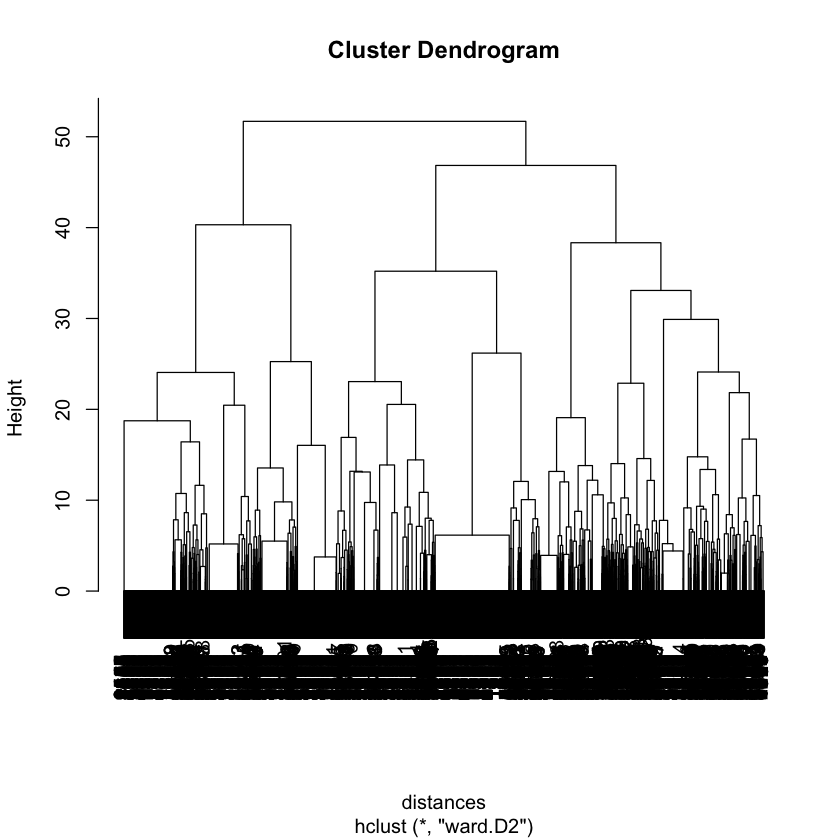

In [151]:
plot(cluster_hi)

Cuts the tree such that there are only 10 clusters

In [155]:
cluster_hi_smol<-cutree(clusterhi, k=10)

Identifying the main genres in each cluster

In [158]:
# an empty matrix with row=#genres and columns=#clusters
Categories<-matrix(0,nrow=19, ncol=10)
for(i in 1:19){
  # i refers to the genre
  # at each iteration, we determine the mean value of each cluster for a single genre 
  # the higher the value, the more significant the genre is in the cluster
  Categories[i,]<-tapply(Data[,i],cluster_hi_smol, mean)
}
rownames(Categories)<-colnames(Data)[1:19]
Categories

Action,0.179775281,0.000000000,0.1263768116,0.3825757576,0.365241636,0.110604333,0.0000000000,0.098993289,0.006116208,0.39460784
Adventure,0.457865169,0.000000000,0.0684057971,0.0340909091,0.396840149,0.025085519,0.0000000000,0.075503356,0.000000000,0.21323529
Animation,0.363764045,0.005725191,0.0023188406,0.0015151515,0.045539033,0.007981756,0.0159362550,0.001677852,0.000000000,0.00000000
Children,0.526685393,0.013358779,0.0075362319,0.0015151515,0.094795539,0.001140251,0.0039840637,0.003355705,0.000000000,0.00000000
Comedy,0.532303371,1.000000000,0.9304347826,0.0128787879,0.121747212,0.168757127,0.0029880478,0.046979866,0.110091743,0.10294118
Crime,0.012640449,0.000000000,0.1460869565,0.5318181818,0.018587361,0.031927024,0.0000000000,0.109060403,0.000000000,0.02450980
Documentary,0.000000000,0.000000000,0.0133333333,0.0022727273,0.005576208,0.009122007,0.0009960159,0.000000000,1.000000000,0.03431373
Drama,0.191011236,0.431297710,0.3408695652,0.6500000000,0.263940520,0.164196123,1.0000000000,0.845637584,0.042813456,0.74019608
Fantasy,0.620786517,0.000000000,0.0081159420,0.0060606061,0.020446097,0.103762828,0.0000000000,0.016778523,0.000000000,0.00245098
Film-Noir,0.000000000,0.000000000,0.0005797101,0.0621212121,0.001858736,0.000000000,0.0000000000,0.010067114,0.000000000,0.00000000
Horror,0.016853933,0.000000000,0.0040579710,0.0348484848,0.116171004,0.916761688,0.0000000000,0.008389262,0.000000000,0.00245098


## 6. Collaborative filtering

Collaborative filtering uses existing information of user ratings to make prediction on missing ratings or to obtain top N recommendations

Types of collaborative filtering techniques:

1. __Baseline model:__ predict missing rating based on average ratings across all user for each item (baseline model 1) OR based on  average ratings across all items for each user (baseline model 2)
2. __User-based collaborative filtering:__ identify similar users and use known ratings of item A by user 1 to predict unknown rating of item A by user 2, where user 1 and 2 are found to be similar
3. __Item-based collaborative filtering:__ identify similar items and use known ratings of item A by user 1 to predict unknown rating of item B by user 1, where item A and B are found to be similar

Load the example dataset

In [160]:
ratings<-read.csv("Dataset/ratings.csv")  
head(ratings)

userId,movieId,rating
1,6,2
1,22,3
1,32,2
1,50,5
1,110,4
1,164,3


### Pre-processing

In [164]:
# an empty matrix with row=#users and column=#movies
Data<-matrix(nrow = length(unique(ratings$userId)), ncol=length(unique(ratings$movieId)))
# naming the row and columns with index of unique users and movies
rownames(Data)<-unique(ratings$userId)
colnames(Data)<-unique(ratings$movieId)
# fill the matrix with the ratings based on userid and movieid
for(i in 1:nrow(ratings)){
  Data[as.character(ratings$userId[i]),as.character(ratings$movieId[i])]<-ratings$rating[i]
}
head(Data)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.matrix(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(wrap

,6,22,32,50,110,164,198,260,296,303,⋯,7213,7252,7274,7275,4828,92481,93855,98956,3782,60189
1,2,3,2,5.0,4,3,3,5,4,3,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NA,NA,3,4.0,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,NA,NA,NA,NA,5,NA,NA,5,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,NA,NA,NA,4.5,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Split the dataset. We want to predict ratings in region: (spl1c,spl2c)
<img src="Images/collab_split1.JPG" width="50%">

__Note: the _sample()_ function will sample randomly and will NOT sample based on a straight cut as illusrated above. It is drawn only to show the split ratio__

In [165]:
set.seed(1)
spl1<-sample(1:nrow(Data),0.98*nrow(Data))
spl1c<-setdiff(1:nrow(Data),spl1) # choose rows not selected by spl1
set.seed(2)
spl2<-sample(1:ncol(Data),0.8*ncol(Data))
spl2c<-setdiff(1:ncol(Data),spl2) # choose columns not selected by spl2

### Baseline model 1

Predict missing rating based on average ratings across all user for each item

In [166]:
Base1<-matrix(nrow=length(spl1c), ncol=length(spl2c))
# for each user id in spl1c
for(i in 1:length(spl1c)){ 
    # mean across the whole of column
    Base1[i,]<-colMeans(Data[spl1,spl2c],na.rm=TRUE) 
    # users would have the same prediction for same item
}
head(Base1)

4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5
4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5
4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5
4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5
4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5
4.124214,1,4.055172,3.633721,3.415301,3.388889,3.5,3.694245,3.805556,3.763158,⋯,1,4,2,4,4,4,3,3.5,3,1.5


### Baseline model 2

Predict missing rating based on average ratings across all items for each user 

In [167]:
Base2<-matrix(nrow=length(spl1c), ncol=length(spl2c))
# for each movie id in spl2c
for(j in 1:length(spl2c)){
    # mean across the whole row
    Base2[,j]<-rowMeans(Data[spl1c,spl2],na.rm=TRUE)
    # items would have the same prediction for same user
}
head(Base2)

3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,⋯,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000,3.750000
3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,⋯,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391,3.817391
3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,⋯,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667,3.866667
4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,⋯,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364,4.136364
3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,⋯,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966,3.568966
3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,⋯,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778,3.152778


### User-based collaborative filtering

Predict missing rating based on average ratings across nearest 250 users for each item

In [169]:
User <- matrix(nrow=length(spl1c),ncol=length(spl2c))
# for temporarily storing correlation between 1 user in spl1c and all users in spl1
Cor<-matrix(nrow=length(spl1),ncol=1) 
# for storing correlation between users in spl1c and users in spl1 in decreasing order
Order<-matrix(nrow=length(spl1c),ncol=length(spl1)) 

# for each user in spl1c
for(i in 1:length(spl1c)){
    # for each user in spl1
    for(j in 1:length(spl1)){
        # comparing the rating pattern between user in spl1c and user in spl1
        Cor[j]<-cor(Data[spl1c[i],spl2],Data[spl1[j],spl2], use="pairwise.complete.obs")
    }
    # sort the correlation in decreasing order and returns the INDEX, not the value
    v<-order(Cor,decreasing = TRUE, na.last = NA) 
    # insert NA to account for users who have no common ratings of movies with the user
    Order[i,]<-c(v,rep(NA,times=length(spl1)-length(v))) 
}
head(Order)

Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j], spl2], use = "pairwise.complete.obs"):
“the standard deviation is zero”Warning message in cor(Data[spl1c[i], spl2], Data[spl1[j],

11,69,108,155,164,348,374,379,381,444,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
33,37,45,53,123,181,260,266,281,298,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,14,31,42,50,55,104,106,108,110,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,26,35,53,81,147,292,309,316,374,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
15,25,47,49,58,143,147,182,183,191,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
21,26,31,128,140,143,181,206,255,281,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [182]:
# for each user in spl1c
for (i in 1:length(spl1c)){
    # Order[i,1:250] returns the indexes of nearest 250 users in spl1 matrix
    # spl1[Order[i,1:250]] returns the ORIGINAL indexes of nearest 250 users in Data matrix
    # Data[spl1[Order[i,1:250]],spl2c] returns the ratings for nearest 250 users for items in spl2c
    # apply a mean across nearest 250 users for each item to generate predicted rating
    User[i,]<-colMeans(Data[spl1[Order[i,1:250]],spl2c],na.rm=TRUE)
}
head(User)

4.176471,1,4.054878,3.692982,3.467391,3.423077,3.300000,3.652174,3.761111,3.666667,⋯,1,4,2,NaN,NaN,NaN,NaN,NaN,3,NaN
4.268657,1,4.057377,3.700000,3.351190,3.208333,3.000000,3.403509,3.761538,3.575000,⋯,NaN,NaN,2,NaN,4,NaN,NaN,NaN,NaN,NaN
4.130719,1,4.126263,3.680851,3.336634,3.366667,3.700000,3.762821,3.830357,3.770833,⋯,NaN,NaN,2,4,4,4,NaN,NaN,NaN,NaN
4.161074,1,4.223077,3.734375,3.282051,3.500000,3.666667,3.566667,3.789855,4.107143,⋯,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,3,NaN
4.187023,NaN,4.070175,3.736111,3.467742,3.300000,3.000000,3.673469,3.838710,3.593750,⋯,NaN,NaN,NaN,NaN,NaN,NaN,3,3.5,NaN,NaN
4.166667,1,4.050633,3.750000,3.394366,3.192308,3.375000,3.769231,3.851852,3.675000,⋯,NaN,NaN,NaN,4,NaN,4,NaN,NaN,NaN,NaN


### Model Comparison

Finding the nearest 250 neighbours to predict ratings achieve a lower RMSE score. Yey!

In [184]:
RMSEBase1<-sqrt(mean((Data[spl1c,spl2c]-Base1)^2, na.rm=TRUE))
RMSEBase1
RMSEBase2<-sqrt(mean((Data[spl1c,spl2c]-Base2)^2, na.rm=TRUE))
RMSEBase2
RMSEUserPred<-sqrt(mean((Data[spl1c,spl2c]-User)^2, na.rm=TRUE))
RMSEUserPred

[1] 0.9310296

[1] 0.9953377

[1] 0.8985567

## 7. Singular Value Decomposition

Given a rectangular matrix X of dimension m x n, a SVD of X is of the form (assume m>n):

\begin{equation*}
X = U S V^{T}
\end{equation*}

where the size of the matrix are
* X: m x m
* U: m x m 
* S: m x n
* Vt: n x n

Note: 
1. Both matrices U and V are orthorgonal matrices, namely $U^{T}U = UU^{T} = I$ and $V^{T}V=VV^{T} = I$ where I is an identity matrix
2. Matrix s is a diagonal matrix with diagonal entries $\sigma_{1},\sigma_{2},..,\sigma_{n}>=0$ where $n=min(m,n)$ at the top and 0's filling the rest of the matrix
3. $\sigma_{1},\sigma_{2},..,\sigma_{n}$ in $S$ is arranged in descending order (i.e. $\sigma_{1}>=\sigma_{2}..$)

### Low rank approximation

Idea: we drop smaller singular values to approximate. E.g. A rank-10 approximation takes the top 10 singular values. Hence, we take the corresponding first 10 columns in $U$ and first 10 rows in $V^{T}$

In [188]:
library(jpeg)
lky<-readJPEG("Dataset/lky.jpg")
s<-svd(lky[,,1])

# rank 10 approximation
lky10<- s$u[,1:10]%*%diag(s$d[1:10])%*%t(s$v[,1:10]) 

# rank 50 approximation
lky50<- s$u[,1:50]%*%diag(s$d[1:50])%*%t(s$v[,1:50]) 

Plot a graph to illustrate the significance of the singular values

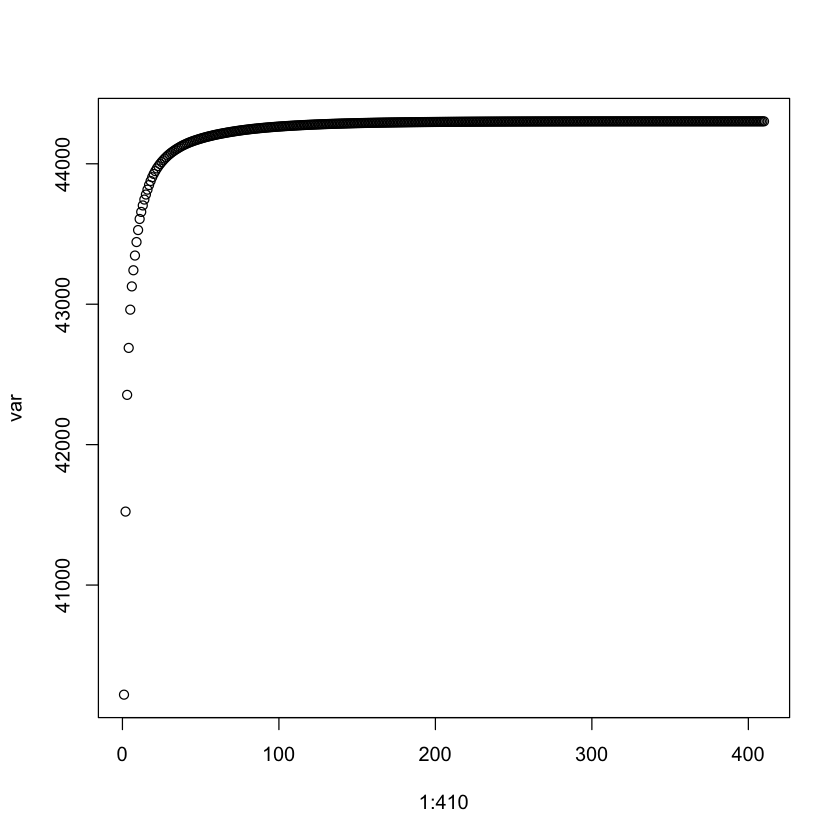

In [189]:
var<-cumsum(s$d^2) # cumulative function
plot(1:410, var)

## 8. Tobit and Censored Data

Censored variables are variables with a large fraction of observations at either the min or max. The following diagram shows a __right censored data__

<img src="Images/censored_data.png" width="80%">

Motivation for Tobit model:
* Modelling observations at the min/max using vanilla linear regression gives erronous results due to mixed signals from features. (i.e. observations at the min/max can have a wide range of features, which is not modelled well by linear regression)
* Removing observations at min/max results in a severe decrease in dataset size

Tobit model deals with censored regression problems. Let's assume a left-censored variable $y$ at 0:

\begin{equation}
  y_{i}=\left\{
  \begin{array}{@{}ll@{}}
    y^{*}, & \text{if}\ y^{*}\geq0 \\
    0, & \text{if}\ y^{*}<0
  \end{array}\right.
\end{equation} 

\begin{equation}
    y^{*} = \beta_{0} + \sum_{j=1}^p \beta_{j}x_{ij} + \epsilon_{i}, \forall i=1,..,n
\end{equation} 

where {$\beta_{0},..,\beta_{p}$} are the model coefficients, ${x_{1},..,x_{p}}$ the predictors, n the number of observations, and $\epsilon$ as the model error. $\epsilon_{i}\sim N(0,\sigma^{2})$ is assumed.

We want to find $\beta$ that maximises the log-likelihood of the observations. Since the data is censored, we need to decompose this into two sections - where the observations were truncated to zero, and those which were not:

$$LL(\beta)=\sum_{y_i=0}l_i(\beta)+\sum_{y_i>0}l_i(\beta)$$

Let us consider the log-likelihood for an observation which was censored (i.e. $y_i=0$). Since $y_i=\max\{y^*_i,0\}$, we assume that $y_i^*\leq0$, that is to say,

\begin{equation}
\begin{split}
l_i(\beta)&=\log\big(P(\beta^Tx_i+\epsilon_i\leq0)\big)\\
&=\log\big(P(\epsilon_i\leq-\beta^Tx_i)\big)\\
&=\log\bigg(\Phi\Big(-\frac{\beta^Tx_i}{\sigma}\Big)\bigg)\\
&=\log\bigg(1-\Phi\Big(\frac{\beta^Tx_i}{\sigma}\Big)\bigg)
\end{split}
\end{equation}

For an uncensored observation $y_i>0$, the log-likelihood of the observation is essentially the log-density that the error $\epsilon_i$ makes up for the difference between $y_i^*=y_i$ and $\beta^Tx_i$. Representing said density as $f_\epsilon(\cdot)$, we have:

\begin{equation}
\begin{split}
l_i(\beta)&=\log\big(f_\epsilon(y_i-\beta^Tx_i)\big)\\
&=\log\bigg(\frac1\sigma\cdot\phi\Big(\frac{y_i-\beta^Tx_i}{\sigma}\Big)\bigg)
\end{split}
\end{equation}

Finally, we write the log-likelihood of the Tobit model parameterised by linear regression coefficients $\beta$ as such:

\begin{equation}
LL(\beta)= \sum_{y_{i}=0}\log\bigg(1-\Phi\Big(\frac{\beta^Tx_i}{\sigma}\Big)\bigg)+ \sum_{y_{i}>0}\log\bigg(\frac1\sigma\cdot\phi\Big(\frac{y_i-\beta^Tx_i}{\sigma}\Big)\bigg)
\end{equation}

Import the necessary library

In [190]:
library(survival)


Attaching package: ‘survival’

The following object is masked from ‘package:rpart’:

    solder



Load the example data

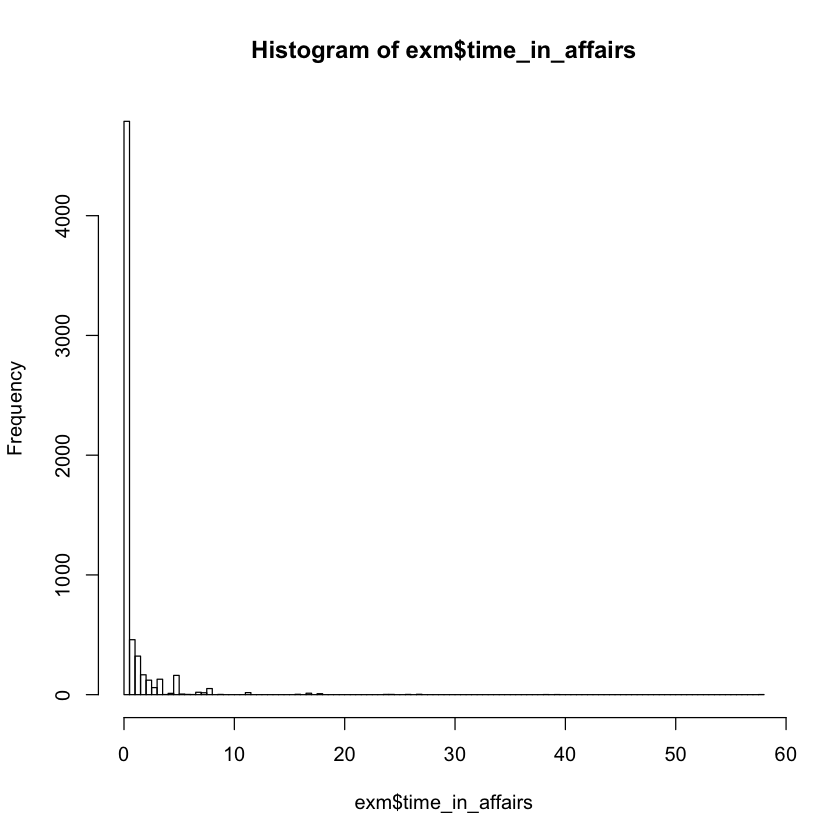

In [194]:
exm<-read.csv("Dataset/extramarital.csv")
hist(exm$time_in_affairs,breaks = 100)

Split the dataset into train and test

In [197]:
set.seed(100)
spl<-sample(nrow(exm),0.7*nrow(exm))
train<-exm[spl,]
test<-exm[-spl,]

### Training

Create a left-censored survival object using _Surv()_ as response and fit a tobit model assuming error is Gaussian

In [199]:
tobit<-survreg(Surv(time_in_affairs, time_in_affairs>0,type="left")~.,data=train, dist="gaussian") 
summary(tobit)


Call:
survreg(formula = Surv(time_in_affairs, time_in_affairs > 0, 
    type = "left") ~ ., data = train, dist = "gaussian")
                  Value Std. Error      z       p
(Intercept)      7.0440     0.8144   8.65 < 2e-16
marriage_rating -1.4505     0.0847 -17.12 < 2e-16
age             -0.0828     0.0288  -2.88 0.00399
yrs_married      0.1043     0.0272   3.83 0.00013
religiosity     -0.8853     0.0985  -8.98 < 2e-16
education       -0.1074     0.0428  -2.51 0.01208
occupation       0.4027     0.0935   4.31 1.7e-05
Log(scale)       1.4759     0.0206  71.73 < 2e-16

Scale= 4.37 

Gaussian distribution
Loglik(model)= -5436.9   Loglik(intercept only)= -5676.2
	Chisq= 478.62 on 6 degrees of freedom, p= 3.4e-100 
Number of Newton-Raphson Iterations: 4 
n= 4456 


### Prediction

In [211]:
tobit_predict<-predict(tobit, newdata=test)
# prediction from tobit model can be negative
tobit_predict

10           12           13           14           24           26 
-0.313908030 -4.770653731 -0.020205065 -3.885391702 -1.635935147 -4.947808482 
          27           30           33           34           35           36 
 0.278302921 -0.099095680 -1.602872756 -3.712364961 -4.730193569  0.348658748 
          40           42           47           55           56           57 
-2.385742637 -2.385742637 -4.533665295 -1.501724402 -1.769505364 -3.053389752 
          60           61           62           64           65           67 
-2.062020000 -0.920657139 -4.492432279 -3.652449624 -3.659104882 -2.883581460 
          69           75           77           78           79           83 
 0.798553832 -3.670579352 -1.881925566 -1.795217553 -4.169688157 -0.099095680 
          86           90           91           93           94           95 
-0.935225640 -1.039829252 -3.757369018 -4.250402820 -2.284594283 -3.784325002 
         104          106          108          111          112          113 
-1.256682566 -1.500480608 -3.132280367 -2.379508069 -2.812273306  0.779025961 
         115          117          118          125          128          134 
-2.827102932 -1.983073920  2.100170511 -1.476302873 -2.412959745 -0.936469434 
         136          139          140          143          150          152 
-1.015651516 -0.351686596 -0.470100148 -1.349368827  0.376357244 -3.524508594 
         156          159          160          172          173          174 
-0.453666308 -0.371917665 -0.545235873 -1.636677660  0.337665666 -1.568227534 
         177          179          181          183          185          187 
-1.709244950 -3.804941510 -2.220062355  1.776708192 -1.941840903 -2.472450650 
         188          191          200          201          207          215 
-0.239063772 -0.202109372 -1.715292958 -3.636225598 -1.689580769 -4.420211113 
         216          220          223          226          230          244 
-3.195126428 -1.337894357  1.776708192 -2.160699611 -3.000129673 -2.032205988 
         246          249          253          254          257          261 
 0.514047562 -0.155158322 -1.664100839 -1.934151665 -3.592461592 -2.334760332 
         262          264          269          276          277          289 
-2.819413694 -2.170930287 -0.480622292 -4.356510544 -3.004257684 -4.466249150 
         296          302          303          308          311          315 
-0.209595885 -1.689580769 -1.869619737 -2.574842797 -3.722805451 -0.570214522 
         317          324          328          330          336          339 
-2.622731072 -1.591137160 -2.549362868 -5.147139319  0.579695124 -0.920657139 
         340          343          348          353          358          361 
-1.790729122 -1.753984536 -0.897777856  0.545049903 -0.018645488 -1.282865694 
         364          367          374          379          387          397 
 0.213770993  0.545049903 -1.753984536  0.692446108 -3.089931717 -1.688336975 
         405          408          409          410          412          415 
 0.384023229  1.615365735  0.514047562  1.095114825 -3.997135701  0.164848739 
         417          421          426          429          431          436 
-1.716326938 -4.691763116  1.776708192 -2.318326492 -1.501724402  0.303573037 
         445          447          450          453          454          457 
 1.033595274 -1.983073920 -5.162881957 -2.066979370 -2.020731518 -3.387082747 
         466          469          473          474          475          477 
-1.161512460 -1.795217553 -3.195126428 -4.009313370 -1.916570787 -0.859347402 
         486          488          500          504          505          509 
-4.389336932 -1.605675319 -1.539172186 -1.516996101 -2.208587885 -0.557827039 
         510          511          512          515          516          519 
-2.655292989 -0.786060852 -0.627727029 -3.191080070 -3.621447283 -3.434834710 
         520          523          527          531         

In [202]:
# tobit model would perform better at detecting individuals who have time_in_affairs=0
table(tobit_predict<=0, test$time_in_affairs==0)

       
        FALSE TRUE
  FALSE    92   43
  TRUE    523 1252

### Survival function and Hazard rate

The survival function, $S(t)$ expresses the probability that a subject survives longer than time t. It is defined as follows:

\begin{equation}
S(t) = P(T\geq t) = 1 - F(t)
\end{equation}

Given that a subject has survived till time t, we are interested in the probability of the event occuring (the subject not surviving): $P(t\leq T\leq t+\Delta t)$. We can then define the hazard rate, $\lambda(t)$, which is the instantaneous rate of occurence of the event:

\begin{equation}
\lambda(t) = \lim_{\Delta t->0}\frac{P(t\leq T\leq t+\Delta t|T\geq t)}{\Delta t} = \lim_{\Delta t->0}\frac{P(t\leq T\leq t+\Delta t)}{P(T\geq t)\Delta t} = \lim_{\Delta->0}\frac{F(t+\Delta t)-F(t)}{S(t)\Delta t} = \frac{f(t)}{S(t)}
\end{equation}

###  Kaplan-Meier estimator

_ __Objective:__ estimate the survival function, $S(t)$_

The Kaplan-Meier estimate of the survival function is defined as such:

\begin{equation}
S(t) = \Pi_{i:t_{i}<t}(1-\frac{d_{i}}{n-{i}})
\end{equation}

This is really simply $\frac{\#people\ alive\ at\ time\ t}{\#people}$

In [213]:
heart<-read.csv("Dataset/heart.csv")
head(heart)

start,stop,event,age,surgery,transplant,id
0,50,1,31,0,0,1
0,6,1,52,0,0,2
0,1,0,54,0,0,3
1,16,1,54,0,1,3
0,36,0,40,0,0,4
36,39,1,40,0,1,4


In [222]:
km<-survfit(Surv(start,stop,event)~1,data=heart)
# details on the fit for the kaplan-meier curve
# impt var are n.risk and n.event
summary(km, censored=TRUE)

Call: survfit(formula = Surv(start, stop, event) ~ 1, data = heart)

   time n.risk n.event censored survival std.err lower 95% CI upper 95% CI
    0.0      0       0        0    1.000 0.00000       1.0000        1.000
    1.0    103       1        2    0.990 0.00966       0.9715        1.000
    2.0    102       3        3    0.961 0.01904       0.9246        0.999
    3.0     99       3        3    0.932 0.02480       0.8847        0.982
    4.0     96       0        2    0.932 0.02480       0.8847        0.982
    4.5     96       0        1    0.932 0.02480       0.8847        0.982
    5.0     96       2        2    0.913 0.02782       0.8597        0.969
    6.0     94       2        1    0.893 0.03043       0.8355        0.955
    8.0     92       1        2    0.883 0.03161       0.8237        0.948
    9.0     91       1        0    0.874 0.03272       0.8119        0.940
   10.0     90       0        2    0.874 0.03272       0.8119        0.940
   11.0     90       0        1

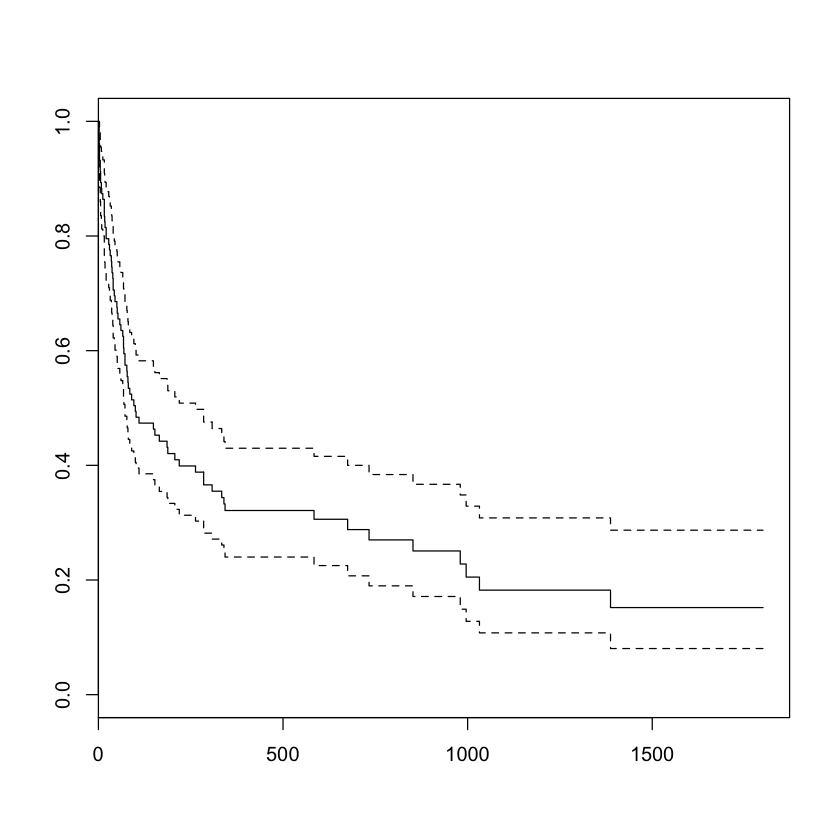

In [216]:
plot(km)

### Cox proporitional hazard 

_ __Objective:__ describe the hazard rate $\lambda(t)$ as a function of predictors_

Cox proporitional hazard model estimate of the hazard rate is defined as follows:

\begin{equation}
\lambda(t) = \lambda_{0}(t)e^{\beta_{1}x_{1}+\beta_{2}x_{2}+..+\beta_{p}x_{p}}
\end{equation}

where $\lambda_{0}$ is the baseline hazard, which corresponds to the value of the hazard when all predictors are equal to zero

In [217]:
# fits a cox proportional hazard model, where age, surgery, transplat variables are used to explain survival
cox<-coxph(Surv(start,stop,event)~age+surgery+transplant,data=heart)
summary(cox)

Call:
coxph(formula = Surv(start, stop, event) ~ age + surgery + transplant, 
    data = heart)

  n= 172, number of events= 75 

               coef exp(coef) se(coef)      z Pr(>|z|)  
age         0.03026   1.03072  0.01397  2.166   0.0303 *
surgery    -0.77139   0.46237  0.35966 -2.145   0.0320 *
transplant  0.01970   1.01990  0.30823  0.064   0.9490  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
age           1.0307     0.9702    1.0029    1.0593
surgery       0.4624     2.1628    0.2285    0.9357
transplant    1.0199     0.9805    0.5574    1.8661

Concordance= 0.599  (se = 0.037 )
Rsquare= 0.06   (max possible= 0.969 )
Likelihood ratio test= 10.55  on 3 df,   p=0.01
Wald test            = 9.53  on 3 df,   p=0.02
Score (logrank) test = 9.85  on 3 df,   p=0.02


In [220]:
summary(survfit(cox))

Call: survfit(formula = cox)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    103       1    0.991 0.00911       0.9732        1.000
    2    102       3    0.964 0.01837       0.9285        1.000
    3     99       3    0.937 0.02446       0.8899        0.986
    5     96       2    0.918 0.02774       0.8656        0.974
    6     94       2    0.900 0.03064       0.8421        0.962
    8     92       1    0.891 0.03197       0.8305        0.956
    9     91       1    0.882 0.03322       0.8191        0.949
   12     89       1    0.873 0.03441       0.8077        0.943
   16     88       3    0.845 0.03757       0.7740        0.921
   17     85       1    0.835 0.03854       0.7629        0.914
   18     84       1    0.826 0.03943       0.7520        0.907
   21     83       2    0.807 0.04096       0.7307        0.892
   28     81       1    0.798 0.04158       0.7204        0.884
   30     80       1    0.788 0.04216       0.7100        0.876
   32     

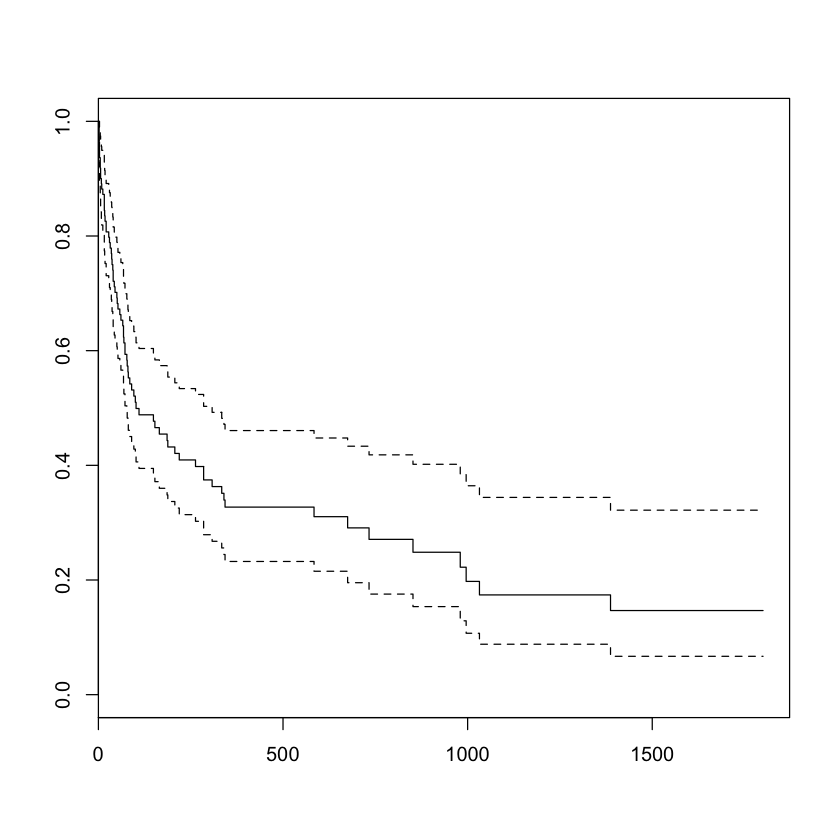

In [218]:
# plot survival fit for cox model
plot(survfit(cox))